# Tip Prediction Project

# Structure of the Notebook
(1) Load Data <br>
(2) Extend Dataframe by Initial Feature Ideas <br>
(3) Analysing Products-DF Influence on Tipping Behaviour <br>
(4) Correlation Matrix to check Relevancy of Features <br>
(5) Main Task A: Train Classification Model <br>
(6) Main Task B: Probability Prediction of Tips (incl. Log-Loss) <br>
(7) Preparation of Final Submission (.csv-files) - includes a dataframe with all features used for prediction and predicted values built on top of existing DFs <br>
(8) Questions

# (0) Initialization

In [1]:
#%pip install seaborn pandas numpy matplotlib scikit-learn holidays
!python --version

Python 3.12.7


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import calendar

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, log_loss
from sklearn.preprocessing import OneHotEncoder

***

# (1) Load Data

In [5]:
# CSV-Dateien: direkt begrenzen´
order_products = pd.read_csv('order_products.csv.zip')
products = pd.read_csv('products.csv.zip')
departments = pd.read_csv('departments.csv.zip')
aisles = pd.read_csv('aisles.csv.zip')
tips = pd.read_csv('tip25_trainingdata.csv.zip')
#tips = tips.dropna(inplace=True) #Drop NaN-Values ERST SPÄTER da wir die zugehörigen Orders dann auch droppen

***

# (2) Extend Orders Dataframe by initial feature ideas

## Liste aller erstellter Features:
- **order_date**: Datum der Bestellung
- **weekday**: Wochentag der BEstellung
- **hour**: Stunde der Bestellung
- **month**: Monat der Bestellung
- **week-start**: Start der Woche, in der die Bestellung ist
- **is_weekend**: binäre Variable (int), um zur Klasisfizierung des Wochenendes 
- **nr_previous_orders**: kumulierte Summe der vorigen Bestellungen eines Users
- **days_since_last_order**: Tage seit letzter Bestellung des Users (erster Wert = 0)
- **month-period**: Start, Mitte oder Ende des Monats klassifiziert (Monat in Drittel aufgeteilt)
- **total_previous_tips**: kumulierte Summe der Tips in den vorigen Bestellungen eines Users
- **tipping_history**: kumulierte durchschnittliche Tip-Häufigkeit eines Users (expanding mean)
- **tip_rate_hour_cum**: kumulierte Tip-Rate je Stunde (Tageszeit)
- **previous_tip**: binäre Variable, ob in vorheriger Bestellung getippt wurde
- **pre_previous_tip**: binäre Variable, ob in vor-voriger Bestellung getippt wurde

<br>

## Erstellung der Features und Test des Einflusses auf die Tip-Variable

In [6]:
orders = pd.read_parquet('orders.parquet')

# Make sure 'order_date' is datetime
orders['order_date'] = pd.to_datetime(orders['order_date'])

# Add weekday name
orders['weekday'] = orders['order_date'].dt.day_name()

# Add hour 
orders["hour"] = orders["order_date"].dt.hour

#Add week
orders["week-start"] = orders["order_date"].dt.to_period("W").dt.start_time
# Flag weekends: Saturday or Sunday
orders['is_weekend'] = orders['weekday'].isin(['Saturday', 'Sunday']).astype(int)

#Add number of previous orders per user
orders = orders.sort_values(["user_id","order_date"])
orders["nr_previous_orders"] = orders.groupby("user_id").cumcount()

#Add days since last order per user
orders["days_since_last_order"] = orders.groupby("user_id")["order_date"].diff().dt.days
orders["days_since_last_order"] = orders["days_since_last_order"].fillna(0).astype(int) #erste Bestellung mit 0 Tagen

#Add month start/middle/end classification
def month_classification(order_date):
    year = order_date.year
    month = order_date.month
    day = order_date.day
    nr_days_month = calendar.monthrange(year, month)[1]
    first_third = nr_days_month // 3
    middle_third = 2 * nr_days_month // 3
    if day <= first_third:
        return "Start"
    elif day <= middle_third:
        return "Middle"
    else:
        return "End"
    
orders["month-period"] = orders["order_date"].dt.date.apply(month_classification)
orders.head(10)

,order_id,user_id,order_date,weekday,hour,week-start,is_weekend,nr_previous_orders,days_since_last_order,month-period
0,1374495,3,2024-03-31 14:05:18,Sunday,14,2024-03-25,1,0,0,End
1,444309,3,2024-04-09 19:45:51,Tuesday,19,2024-04-08,0,1,9,Start
2,3002854,3,2024-04-30 16:25:20,Tuesday,16,2024-04-29,0,2,20,End
3,2037211,3,2024-05-20 18:31:28,Monday,18,2024-05-20,0,3,20,Middle
4,2710558,3,2024-06-01 17:52:27,Saturday,17,2024-05-27,1,4,11,Start
5,1972919,3,2024-06-08 16:55:12,Saturday,16,2024-06-03,1,5,6,Start
6,1839752,3,2024-06-15 15:04:06,Saturday,15,2024-06-10,1,6,6,Middle
7,3225766,3,2024-06-22 17:49:38,Saturday,17,2024-06-17,1,7,7,End
8,3160850,3,2024-06-29 16:49:34,Saturday,16,2024-06-24,1,8,6,End
9,676467,3,2024-07-16 16:27:44,Tuesday,16,2024-07-15,0,9,16,Middle


In [7]:
# Merge Orders & Tips 
# Drop last Order per user where tip is NaN
orders_and_tips = pd.merge(orders, tips, on="order_id", how="left") 
orders_and_tips = orders_and_tips[orders_and_tips["tip"].notna()] #drop last order per user where tip is NaN
orders_and_tips.head(10)

,order_id,user_id,order_date,weekday,hour,week-start,is_weekend,nr_previous_orders,days_since_last_order,month-period,Unnamed: 0,tip
0,1374495,3,2024-03-31 14:05:18,Sunday,14,2024-03-25,1,0,0,End,0.0,True
1,444309,3,2024-04-09 19:45:51,Tuesday,19,2024-04-08,0,1,9,Start,1.0,False
2,3002854,3,2024-04-30 16:25:20,Tuesday,16,2024-04-29,0,2,20,End,2.0,False
3,2037211,3,2024-05-20 18:31:28,Monday,18,2024-05-20,0,3,20,Middle,3.0,False
4,2710558,3,2024-06-01 17:52:27,Saturday,17,2024-05-27,1,4,11,Start,4.0,True
5,1972919,3,2024-06-08 16:55:12,Saturday,16,2024-06-03,1,5,6,Start,5.0,True
6,1839752,3,2024-06-15 15:04:06,Saturday,15,2024-06-10,1,6,6,Middle,6.0,False
7,3225766,3,2024-06-22 17:49:38,Saturday,17,2024-06-17,1,7,7,End,7.0,False
8,3160850,3,2024-06-29 16:49:34,Saturday,16,2024-06-24,1,8,6,End,8.0,False
9,676467,3,2024-07-16 16:27:44,Tuesday,16,2024-07-15,0,9,16,Middle,9.0,False


## Analyse von General Order Features auf Tipping Behaviour

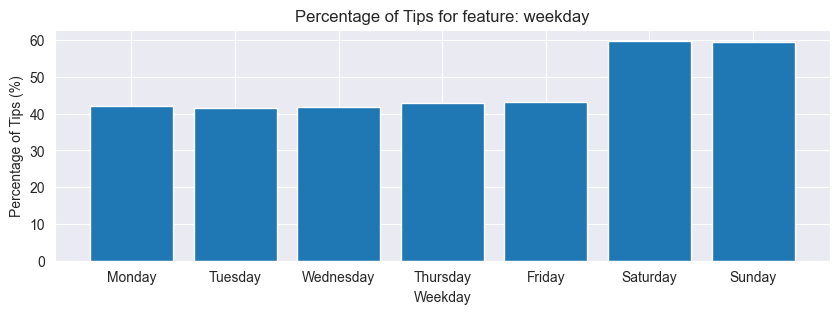

Höchste Tip-Wkeiten
                 tip
weekday             
Saturday   59.832629
Sunday     59.406033
Friday     43.207775
Thursday    42.99998
Monday     42.083245
Wednesday  41.904066
Tuesday    41.441993


In [51]:
### Testing weekday influence
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
tip_by_testfeature = orders_and_tips[["weekday","tip"]].groupby("weekday").mean()*100
tip_by_testfeature = tip_by_testfeature.reindex(weekday_order)
plt.figure(figsize=(10, 3))
plt.bar(tip_by_testfeature.index, tip_by_testfeature["tip"])
plt.xlabel('Weekday')
plt.ylabel('Percentage of Tips (%)')
plt.title('Percentage of Tips for feature: weekday')
plt.show()
print("Höchste Tip-Wkeiten")
print(tip_by_testfeature.sort_values(by="tip",ascending=False).head(10))

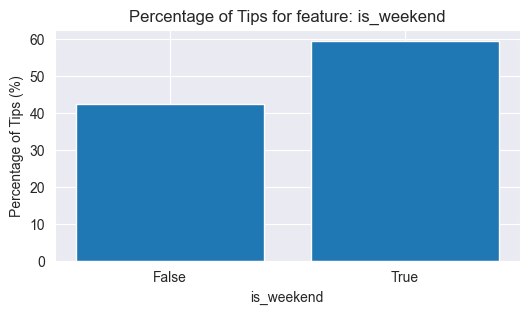

Korrelation:  0.1634585571320028
Höchste Tip-Wkeiten
                  tip
is_weekend           
1           59.609686
0           42.328774


In [7]:
### Testing is_weekend influence
tip_by_testfeature = orders_and_tips[["is_weekend","tip"]].groupby("is_weekend").mean()*100
plt.figure(figsize=(6, 3))
plt.bar(tip_by_testfeature.index, tip_by_testfeature["tip"])
plt.xlabel('is_weekend')
plt.ylabel('Percentage of Tips (%)')
plt.xticks([0,1], ['False', 'True'], rotation=0)
plt.title('Percentage of Tips for feature: is_weekend')
plt.show()
corr_matrix = orders_and_tips["is_weekend"].corr(orders_and_tips["tip"])
print("Korrelation: ", corr_matrix)
print("Höchste Tip-Wkeiten")
print(tip_by_testfeature.sort_values(by="tip",ascending=False).head(10))

#### Wochenende hat einen Einfluss! (weekday und is_weekend zeigen den gleichen Effekt in unterschiedlichen Granularitäten)

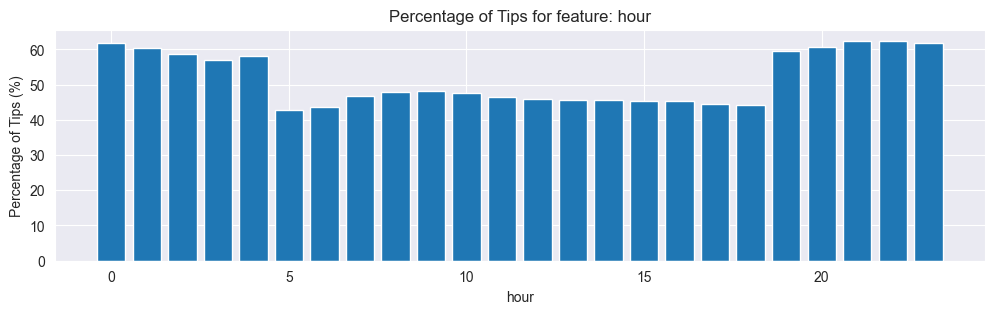

Korrelation:  0.03617046887262718
Höchste Tip-Wkeiten
            tip
hour           
22    62.448434
21    62.304509
23    61.817165
0     61.731813
20    60.537998
1     60.248578
19    59.416679
2     58.789723
4     58.223395
3     56.969697


In [8]:
### Testing hour influence
tip_by_testfeature = orders_and_tips[["hour","tip"]].groupby("hour").mean()*100
plt.figure(figsize=(12, 3))
plt.bar(tip_by_testfeature.index, tip_by_testfeature["tip"])
plt.xlabel('hour')
plt.ylabel('Percentage of Tips (%)')
plt.title('Percentage of Tips for feature: hour')
plt.show()
corr_matrix = orders_and_tips["hour"].corr(orders_and_tips["tip"])
print("Korrelation: ", corr_matrix)
print("Höchste Tip-Wkeiten")
print(tip_by_testfeature.sort_values(by="tip",ascending=False).head(10))

#### Tageszeit der Bestellung hat einen Einfluss

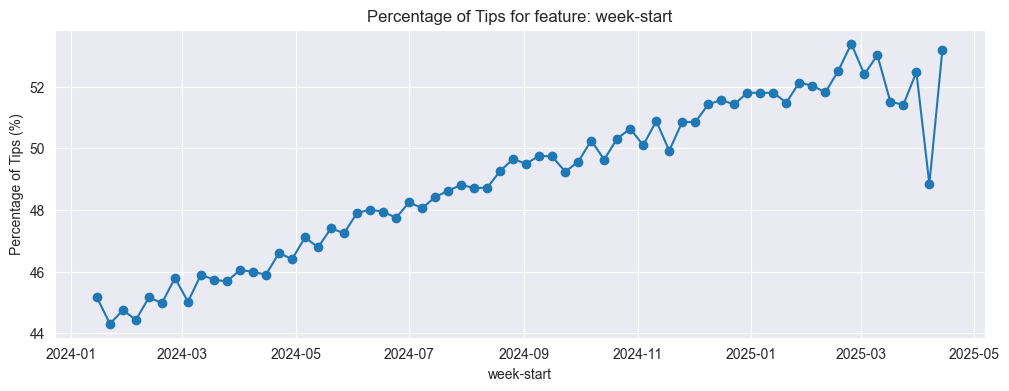

Höchste Tip-Wkeiten
                  tip
week-start           
2025-02-24   53.38822
2025-04-14  53.191489
2025-03-10  53.017985
2025-02-17  52.510858
2025-03-31  52.468619
2025-03-03  52.393928
2025-01-27  52.130682
2025-02-03  52.026821
2025-02-10  51.810748
2024-12-30  51.801655


In [9]:
### Testing week-start influence
tip_by_testfeature = orders_and_tips[["week-start","tip"]].groupby("week-start").mean()*100
plt.figure(figsize=(12, 4))
plt.plot(tip_by_testfeature.index, tip_by_testfeature["tip"], marker="o")
plt.xlabel('week-start')
plt.ylabel('Percentage of Tips (%)')
plt.title('Percentage of Tips for feature: week-start')
plt.show()
print("Höchste Tip-Wkeiten")
print(tip_by_testfeature.sort_values(by="tip",ascending=False).head(10))

#### Tip Wahrscheinlichkeit nimmt mit der Zeit zu
#### Achtung bzgl. Ende: starke Schwankungen durch wenige Bestellungen im Endbereich des Features 

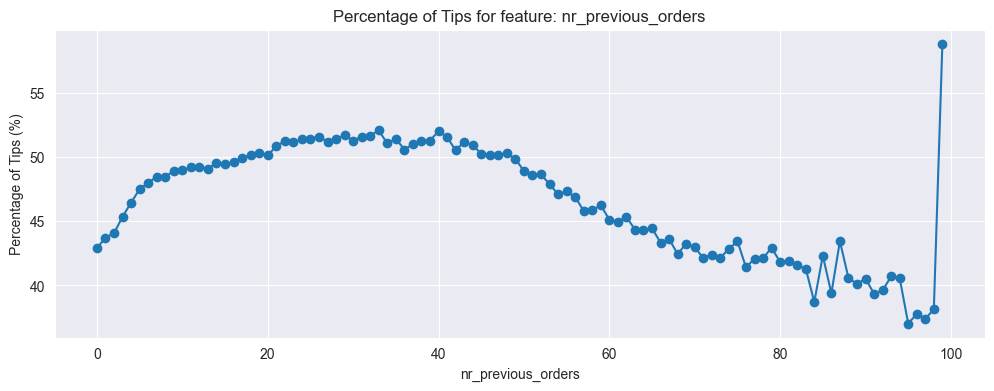

Korrelation:  -0.002178290061804034
Höchste Tip-Wkeiten
                          tip
nr_previous_orders           
99                  58.823529
33                  52.061307
40                  51.999059
29                   51.73646
32                  51.666059
26                  51.590088
31                  51.580069
41                  51.558558
25                   51.42513
35                  51.408264


In [10]:
### Testing nr_previous_orders influence
tip_by_testfeature = orders_and_tips[["nr_previous_orders","tip"]].groupby("nr_previous_orders").mean()*100
plt.figure(figsize=(12, 4))
plt.plot(tip_by_testfeature.index, tip_by_testfeature["tip"], marker="o")
plt.xlabel('nr_previous_orders')
plt.ylabel('Percentage of Tips (%)')
plt.title('Percentage of Tips for feature: nr_previous_orders')
plt.show()
corr_matrix = orders_and_tips["nr_previous_orders"].corr(orders_and_tips["tip"])
print("Korrelation: ", corr_matrix)
print("Höchste Tip-Wkeiten")
print(tip_by_testfeature.sort_values(by="tip",ascending=False).head(10))

#### Tip Wahrscheinlichkeit nimmt bis zu ~20 Bestellungen eines Users zu, dort erreicht sie ein Plateau bis ~40 und sinkt danach wieder. Korrelation negativ.
#### Ende: starke Schwankungen durch wenige Bestellungen im Endbereich des Features 

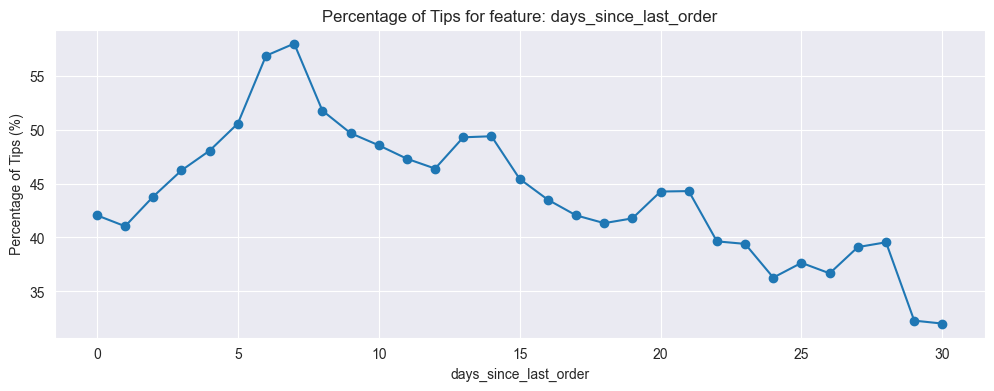

Korrelation:  0.0031307832490313024
Höchste Tip-Wkeiten
                             tip
days_since_last_order           
7                      58.005665
6                      56.877375
8                      51.780681
5                      50.578879
9                      49.684993
14                     49.397636
13                      49.29972
10                     48.555957
4                      48.061941
11                     47.307665


In [11]:
### Testing days_since_last_order influence
tip_by_testfeature = orders_and_tips[["days_since_last_order","tip"]].groupby("days_since_last_order").mean()*100
plt.figure(figsize=(12, 4))
plt.plot(tip_by_testfeature.index, tip_by_testfeature["tip"], marker="o")
plt.xlabel('days_since_last_order')
plt.ylabel('Percentage of Tips (%)')
plt.title('Percentage of Tips for feature: days_since_last_order')
plt.show()
corr_matrix = orders_and_tips["days_since_last_order"].corr(orders_and_tips["tip"])
print("Korrelation: ", corr_matrix)
print("Höchste Tip-Wkeiten")
print(tip_by_testfeature.sort_values(by="tip",ascending=False).head(10))

#### Die Tip Wahrscheinlichkeit nimmt mit größer werdendem Abstand zur letzten Bestellung ab der 7ten Bestellung ab. Bis dahin steigt sie.

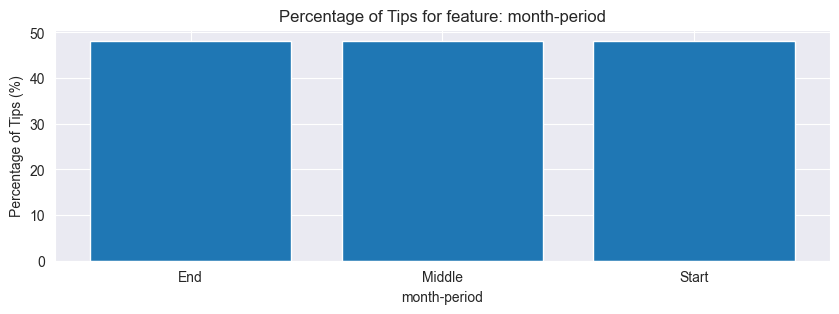

Höchste Tip-Wkeiten
                    tip
month-period           
End           48.165664
Start          48.16009
Middle        48.121088


In [12]:
### Testing month-period influence
tip_by_testfeature = orders_and_tips[["month-period","tip"]].groupby("month-period").mean()*100
plt.figure(figsize=(10, 3))
plt.bar(tip_by_testfeature.index, tip_by_testfeature["tip"])
plt.xlabel('month-period')
plt.ylabel('Percentage of Tips (%)')
plt.title('Percentage of Tips for feature: month-period')
plt.show()
print("Höchste Tip-Wkeiten")
print(tip_by_testfeature.sort_values(by="tip",ascending=False).head(10))

#### Der monatliche Zeitpunkt Beginn/Mitte/Ende des Monats hat keinen Einflus auf die Tip-Wahrscheinlichkeit

In [8]:
#Testing User Tip-Rate (Tipping_History)
#Making sure it´s sorted again
orders_and_tips = orders_and_tips.sort_values(["user_id","order_date"])
orders_and_tips["tipping_history"] = orders_and_tips.groupby("user_id")["tip"].apply(lambda x: x.shift().expanding().mean()).reset_index(level=0, drop=True)
orders_and_tips.head(20)

,order_id,user_id,order_date,weekday,hour,week-start,is_weekend,nr_previous_orders,days_since_last_order,month-period,Unnamed: 0,tip,tipping_history
0,1374495,3,2024-03-31 14:05:18,Sunday,14,2024-03-25,1,0,0,End,0.0,True,NaN
1,444309,3,2024-04-09 19:45:51,Tuesday,19,2024-04-08,0,1,9,Start,1.0,False,1.000000
2,3002854,3,2024-04-30 16:25:20,Tuesday,16,2024-04-29,0,2,20,End,2.0,False,0.500000
3,2037211,3,2024-05-20 18:31:28,Monday,18,2024-05-20,0,3,20,Middle,3.0,False,0.333333
4,2710558,3,2024-06-01 17:52:27,Saturday,17,2024-05-27,1,4,11,Start,4.0,True,0.250000
5,1972919,3,2024-06-08 16:55:12,Saturday,16,2024-06-03,1,5,6,Start,5.0,True,0.400000
6,1839752,3,2024-06-15 15:04:06,Saturday,15,2024-06-10,1,6,6,Middle,6.0,False,0.500000
7,3225766,3,2024-06-22 17:49:38,Saturday,17,2024-06-17,1,7,7,End,7.0,False,0.428571
8,3160850,3,2024-06-29 16:49:34,Saturday,16,2024-06-24,1,8,6,End,8.0,False,0.375000
9,676467,3,2024-07-16 16:27:44,Tuesday,16,2024-07-15,0,9,16,Middle,9.0,False,0.333333


In [9]:
corr_matrix = orders_and_tips["tipping_history"].corr(orders_and_tips["tip"])
print("Korrelation: ", corr_matrix)

Korrelation:  0.5303929818180676


### Die Tip-Rate in den vorherigen Bestellungen hat eine hohe Korrelation mit den Tips.

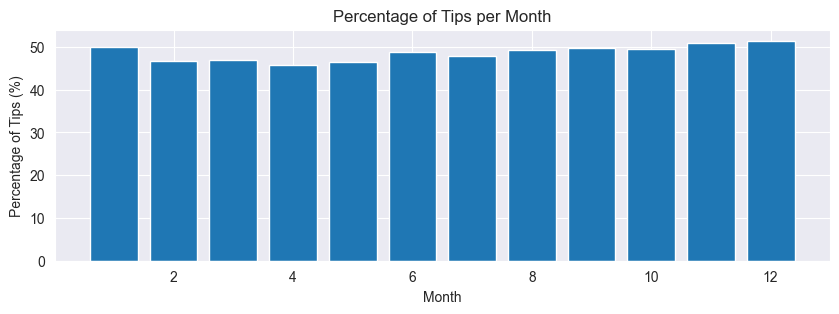

In [10]:
# Add Month
orders_and_tips['month'] = orders_and_tips['order_date'].dt.month


# Effekt des Monats
tip_by_testfeature = orders_and_tips[["month", "tip"]].groupby("month").mean() * 100
plt.figure(figsize=(10,3))
plt.bar(tip_by_testfeature.index, tip_by_testfeature["tip"])
plt.xlabel("Month")
plt.ylabel("Percentage of Tips (%)")
plt.title("Percentage of Tips per Month")
plt.show()

### Kein bzw. kaum Einfluss des Monats auf die Tip-Wahrscheinlichkeit

In [11]:
orders_and_tips = orders_and_tips.sort_values(["user_id", "order_date"])

# Anzahl vorheriger Tips
orders_and_tips['tip'] = orders_and_tips['tip'].astype(bool) 
orders_and_tips["total_previous_tips"] = orders_and_tips.groupby("user_id")["tip"].cumsum() - orders_and_tips["tip"] # Tip abziehen, da cumsum kumulative Summe inklusiver aktueller Zeile ist, aber diese Information in Zelle nicht vorliegt (Zeitreihe)

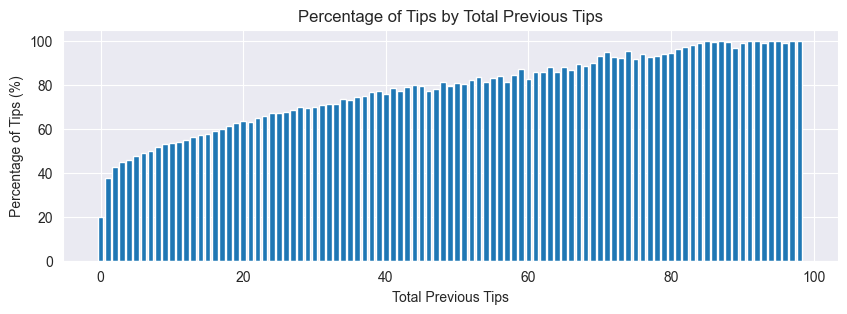

In [12]:
# Effekt des Monats
tip_by_testfeature = orders_and_tips[["total_previous_tips", "tip"]].groupby("total_previous_tips").mean() * 100
plt.figure(figsize=(10,3))
plt.bar(tip_by_testfeature.index, tip_by_testfeature["tip"])
plt.xlabel("Total Previous Tips")
plt.ylabel("Percentage of Tips (%)")
plt.title("Percentage of Tips by Total Previous Tips")
plt.show()

#### Effekt besteht für Total Previous Tips 

In [13]:
#Previous und Pre-Previous Tips als Features erstellt
orders_and_tips = orders_and_tips.sort_values(['user_id', 'order_date'])

orders_and_tips['previous_tip'] = orders_and_tips.groupby("user_id")['tip'].shift(1)
orders_and_tips['pre_previous_tip'] = orders_and_tips.groupby("user_id")['tip'].shift(2)

In [14]:
# Erstellen von kumulativer Tip-Rate je Stunde
# Sortiere nach Zeit, falls noch nicht geschehen
orders_and_tips = orders_and_tips.sort_values("order_date")

# Berechne kumulative Tipp-Rate je Stunde (ohne Leakage)
orders_and_tips['tip_rate_hour_cum'] = (
    orders_and_tips
    .groupby('hour')['tip']
    .transform(lambda x: x.shift().expanding().mean())
)

# Optional: Ersetze NaNs durch globalen Tipp-Mittelwert
global_tip_mean = orders_and_tips['tip'].mean()
orders_and_tips['tip_rate_hour_cum'] = orders_and_tips['tip_rate_hour_cum'].fillna(global_tip_mean)

In [15]:
# Übersicht über aktuelles DataFrame
orders_and_tips.head(10)

,order_id,user_id,order_date,weekday,hour,week-start,is_weekend,nr_previous_orders,days_since_last_order,month-period,Unnamed: 0,tip,tipping_history,month,total_previous_tips,previous_tip,pre_previous_tip,tip_rate_hour_cum
622282,1510472,87063,2024-01-17 00:17:26,Wednesday,0,2024-01-15,0,0,0,Middle,622282.0,True,NaN,1,0,NaN,NaN,0.481493
164612,2707022,22717,2024-01-17 00:24:45,Wednesday,0,2024-01-15,0,0,0,Middle,164612.0,False,NaN,1,0,NaN,NaN,1.000000
896772,1789128,125953,2024-01-17 06:42:03,Wednesday,6,2024-01-15,0,0,0,Middle,896772.0,False,NaN,1,0,NaN,NaN,0.481493
408959,2345092,57110,2024-01-17 08:08:49,Wednesday,8,2024-01-15,0,0,0,Middle,408959.0,False,NaN,1,0,NaN,NaN,0.481493
1346660,2262337,189818,2024-01-17 08:12:16,Wednesday,8,2024-01-15,0,0,0,Middle,1346660.0,False,NaN,1,0,NaN,NaN,0.000000
636230,501461,89021,2024-01-17 08:14:05,Wednesday,8,2024-01-15,0,0,0,Middle,636230.0,True,NaN,1,0,NaN,NaN,0.000000
703679,3251724,98368,2024-01-17 08:35:56,Wednesday,8,2024-01-15,0,0,0,Middle,703679.0,True,NaN,1,0,NaN,NaN,0.333333
1251452,1122415,176543,2024-01-17 08:45:30,Wednesday,8,2024-01-15,0,0,0,Middle,1251452.0,False,NaN,1,0,NaN,NaN,0.500000
49626,411552,6891,2024-01-17 09:08:57,Wednesday,9,2024-01-15,0,0,0,Middle,49626.0,True,NaN,1,0,NaN,NaN,0.481493
710763,2462518,99335,2024-01-17 09:16:51,Wednesday,9,2024-01-15,0,0,0,Middle,710763.0,False,NaN,1,0,NaN,NaN,1.000000


#### <u> Subsection: Einfluss der Anzahl Produkte je Bestellung </u>

"orders_with_counts"-DF zur Analyse der Anzahl Produkte je Bestellung
- product_count: Anzahl Bestellungen in einer Order

In [21]:
# Testing number of products per order
product_counts = order_products.groupby("order_id").size().reset_index(name="product_count")
product_counts.head()
orders_with_counts = orders_and_tips.merge(product_counts, on="order_id", how="left")
orders_with_counts.head()

,order_id,user_id,order_date,weekday,hour,week-start,is_weekend,nr_previous_orders,days_since_last_order,month-period,Unnamed: 0,tip,tipping_history,month,total_previous_tips,previous_tip,pre_previous_tip,tip_rate_hour_cum,product_count
0,1510472,87063,2024-01-17 00:17:26,Wednesday,0,2024-01-15,0,0,0,Middle,622282.0,True,NaN,1,0,NaN,NaN,0.481493,16
1,2707022,22717,2024-01-17 00:24:45,Wednesday,0,2024-01-15,0,0,0,Middle,164612.0,False,NaN,1,0,NaN,NaN,1.000000,26
2,1789128,125953,2024-01-17 06:42:03,Wednesday,6,2024-01-15,0,0,0,Middle,896772.0,False,NaN,1,0,NaN,NaN,0.481493,12
3,2345092,57110,2024-01-17 08:08:49,Wednesday,8,2024-01-15,0,0,0,Middle,408959.0,False,NaN,1,0,NaN,NaN,0.481493,1
4,2262337,189818,2024-01-17 08:12:16,Wednesday,8,2024-01-15,0,0,0,Middle,1346660.0,False,NaN,1,0,NaN,NaN,0.000000,5


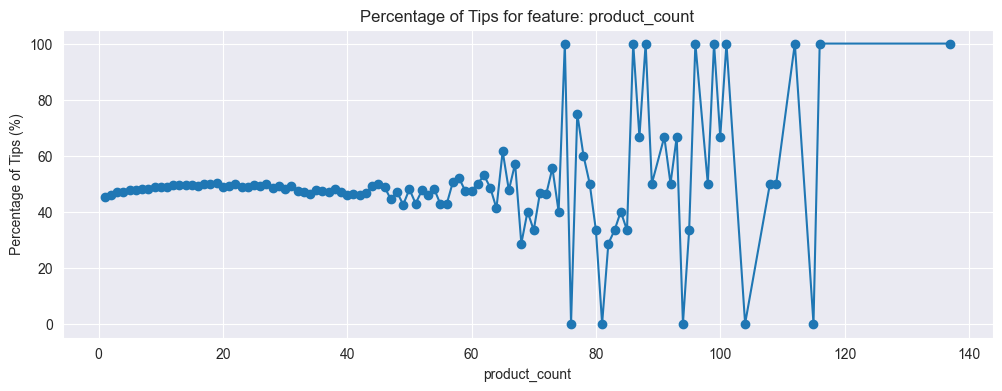

Korrelation:  0.01483442666162068
Höchste Tip-Wkeiten
                 tip
product_count       
137            100.0
101            100.0
96             100.0
88             100.0
86             100.0
75             100.0
112            100.0
116            100.0
99             100.0
77              75.0


In [22]:
### Testing product_counts influence
tip_by_testfeature = orders_with_counts[["product_count","tip"]].groupby("product_count").mean()*100
plt.figure(figsize=(12, 4))
plt.plot(tip_by_testfeature.index, tip_by_testfeature["tip"], marker="o")
plt.xlabel('product_count')
plt.ylabel('Percentage of Tips (%)')
plt.title('Percentage of Tips for feature: product_count')
plt.show()
corr_matrix = orders_with_counts["product_count"].corr(orders_with_counts["tip"])
print("Korrelation: ", corr_matrix)
print("Höchste Tip-Wkeiten")
print(tip_by_testfeature.sort_values(by="tip",ascending=False).head(10))

#### Kein bis geringer Einfluss auf die Tip-Wahrscheinlichkeit 
#### Ende: nur Einzelbestellungen (0% oder 100%) bzw. sehr wenige Bestellungen führen zu extremen Schwankungen bei den Wahrscheinlichkeiten des Product Counts - daher Product Count begrenzt

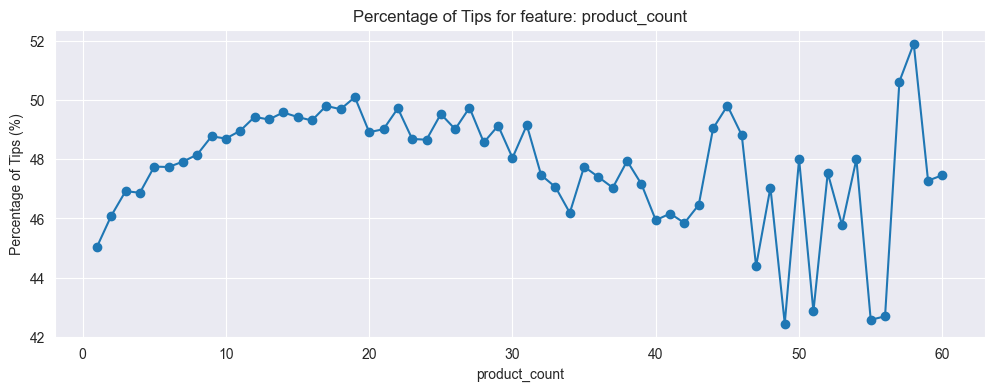

Korrelation:  0.014913054382405417
Höchste Tip-Wkeiten
                     tip
product_count           
58             51.898734
57             50.617284
19             50.089547
45             49.802372
17             49.796373
27             49.736247
22             49.713833
18             49.683922
14             49.574139
25             49.522293


In [23]:
# Extremfälle ignoriert
orders_with_counts = orders_with_counts[orders_with_counts["product_count"]<=60]
### Testing product_counts influence
tip_by_testfeature = orders_with_counts[["product_count","tip"]].groupby("product_count").mean()*100
plt.figure(figsize=(12, 4))
plt.plot(tip_by_testfeature.index, tip_by_testfeature["tip"], marker="o")
plt.xlabel('product_count')
plt.ylabel('Percentage of Tips (%)')
plt.title('Percentage of Tips for feature: product_count')
plt.show()
corr_matrix = orders_with_counts["product_count"].corr(orders_with_counts["tip"])
print("Korrelation: ", corr_matrix)
print("Höchste Tip-Wkeiten")
print(tip_by_testfeature.sort_values(by="tip",ascending=False).head(10))

#### Geringe Schwankungen, jedoch in einem Bereich von ~8 Prozentpunkten 
#### Userspezifischer Indikator, kein allgemeingültiges Modell basierend auf User-Daten möglich - s. Fragen

***

# (3) <u> Analysing Products-DF Influence on Tipping Behaviour </u>
### Merge von order_products, products und orders zur Analyse von aisle_id und department_id bzw. deren Einfluss auf Tipping Behaviour

Größe der Bestellungen <br>
Regelmäßigkeit der Bestellungen <br>
Welches produkt am meisten tips hat (department = Art des Produkts, aisles = genaue Kategorie)


In [24]:
# Dateien einlesen
order_products = pd.read_csv('order_products.csv.zip')
products = pd.read_csv('products.csv.zip')
departments = pd.read_csv('departments.csv.zip')
aisles = pd.read_csv('aisles.csv.zip')
orders2 = pd.read_parquet('orders.parquet')

In [25]:
# Merge von order_products und products
order_products_details = pd.merge(order_products, products, on="product_id", how="left")
order_products_details = order_products_details.drop(columns="product_name")
order_products_details.head()

,order_id,product_id,add_to_cart_order,aisle_id,department_id
0,1,49302,1,120,16
1,1,11109,2,108,16
2,1,10246,3,83,4
3,1,49683,4,83,4
4,1,43633,5,95,15


In [26]:
# Merge des vorig erstellten Datensatzes mit orders
orders_and_order_products_details = pd.merge(orders2, order_products_details, on="order_id", how="left")
orders_and_order_products_details.head()

,order_id,user_id,order_date,product_id,add_to_cart_order,aisle_id,department_id
0,1374495,3,2024-03-31 14:05:18,9387.0,1.0,24.0,4.0
1,1374495,3,2024-03-31 14:05:18,17668.0,2.0,91.0,16.0
2,1374495,3,2024-03-31 14:05:18,15143.0,3.0,24.0,4.0
3,1374495,3,2024-03-31 14:05:18,16797.0,4.0,24.0,4.0
4,1374495,3,2024-03-31 14:05:18,39190.0,5.0,91.0,16.0


In [27]:
# Merge mit tips zum Testen
orders_details_and_tip = pd.merge(orders_and_order_products_details, tips, on="order_id", how="left")
orders_details_and_tip.head()

,order_id,user_id,order_date,product_id,add_to_cart_order,aisle_id,department_id,Unnamed: 0,tip
0,1374495,3,2024-03-31 14:05:18,9387.0,1.0,24.0,4.0,0.0,True
1,1374495,3,2024-03-31 14:05:18,17668.0,2.0,91.0,16.0,0.0,True
2,1374495,3,2024-03-31 14:05:18,15143.0,3.0,24.0,4.0,0.0,True
3,1374495,3,2024-03-31 14:05:18,16797.0,4.0,24.0,4.0,0.0,True
4,1374495,3,2024-03-31 14:05:18,39190.0,5.0,91.0,16.0,0.0,True


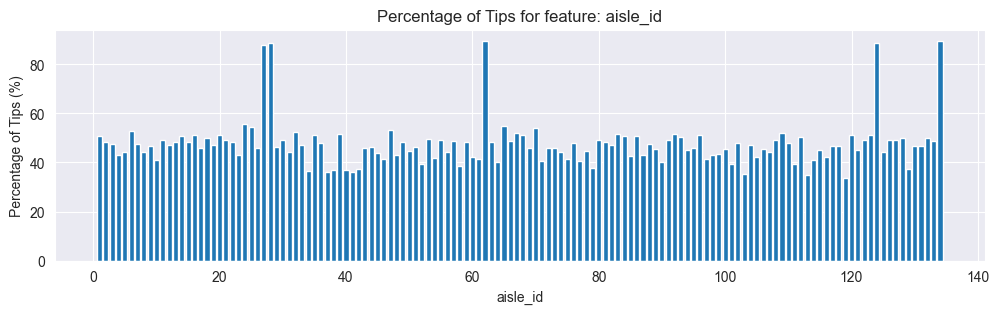

Korrelation:  -0.0119214159753595
10 höchste Tip-Wkeiten
                tip
aisle_id           
62.0      89.683279
134.0     89.441277
28.0      88.634412
124.0     88.630679
27.0       87.85018
24.0      55.715457
65.0       54.93345
25.0      54.343247
70.0      54.240416
47.0        53.0562


In [35]:
### Testing aisle influence
tip_by_testfeature = orders_details_and_tip[["aisle_id","tip"]].groupby("aisle_id").mean()*100
plt.figure(figsize=(12, 3))
plt.bar(tip_by_testfeature.index, tip_by_testfeature["tip"])
plt.xlabel('aisle_id')
plt.ylabel('Percentage of Tips (%)')
plt.title('Percentage of Tips for feature: aisle_id')
plt.show()
corr_matrix = orders_details_and_tip["aisle_id"].corr(orders_details_and_tip["tip"])
print("Korrelation: ", corr_matrix)
print("10 höchste Tip-Wkeiten")
print(tip_by_testfeature.sort_values(by="tip",ascending=False).head(10))


#### Nur wenige Aisles mit einem tatsächlichen Einfluss auf das Tipping-Verhalten 

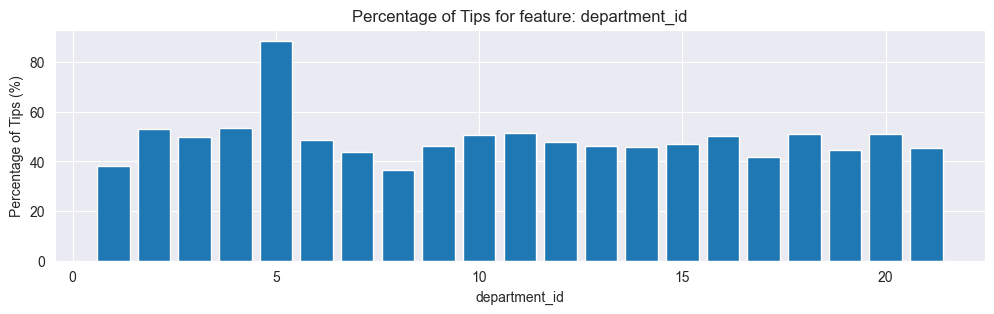

Korrelation:  -0.015029712534100844
10 höchste Tip-Wkeiten
                     tip
department_id           
5.0            88.661639
4.0            53.240985
2.0            52.926518
11.0           51.324899
20.0           51.160257
18.0           51.017835
10.0           50.545943
16.0           50.067001
3.0            49.680503
6.0            48.654744


In [36]:
### Testing department influence
tip_by_testfeature = orders_details_and_tip[["department_id","tip"]].groupby("department_id").mean()*100
plt.figure(figsize=(12, 3))
plt.bar(tip_by_testfeature.index, tip_by_testfeature["tip"])
plt.xlabel('department_id')
plt.ylabel('Percentage of Tips (%)')
plt.title('Percentage of Tips for feature: department_id')
plt.show()
corr_matrix = orders_details_and_tip["department_id"].corr(orders_details_and_tip["tip"])
print("Korrelation: ", corr_matrix)
print("10 höchste Tip-Wkeiten")
print(tip_by_testfeature.sort_values(by="tip",ascending=False).head(10))

#### Einzelnes Department (Alkohol) mit Einfluss auf Tipping Behaviour - die restlichen Departments teilen sich sehr ähnliche Wahrscheinlichkeiten

In [37]:
### Testing product influence
tip_by_testfeature = orders_details_and_tip[["product_id","tip"]].groupby("product_id").mean()*100
# plt.figure(figsize=(12, 3))
# plt.bar(tip_by_testfeature.index, tip_by_testfeature["tip"])
# plt.xlabel('product_id')
# plt.ylabel('Percentage of Tips (%)')
# plt.title('Percentage of Tips for feature: product_id')
# plt.show()
# plot dauert ne gute minute
corr_matrix = orders_details_and_tip["product_id"].corr(orders_details_and_tip["tip"])
print("Korrelation: ", corr_matrix)
print("10 höchste Tip-Wkeiten")
print(tip_by_testfeature.sort_values(by="tip",ascending=False).head(10))

Korrelation:  0.0018724341012808484
10 höchste Tip-Wkeiten
              tip
product_id       
35397.0     100.0
15859.0     100.0
6590.0      100.0
30335.0     100.0
24258.0     100.0
6591.0      100.0
15833.0     100.0
15836.0     100.0
24266.0     100.0
15847.0     100.0


#### Da kein wesentlicher Zusammenhang in ausreichender Breite festgestellt wurde, wird kein Merge des DF "order_details_and_tip" und "orders_and_tips" DF durchgeführt
***

# (4) Correlation Matrix to check Relevancy of Features

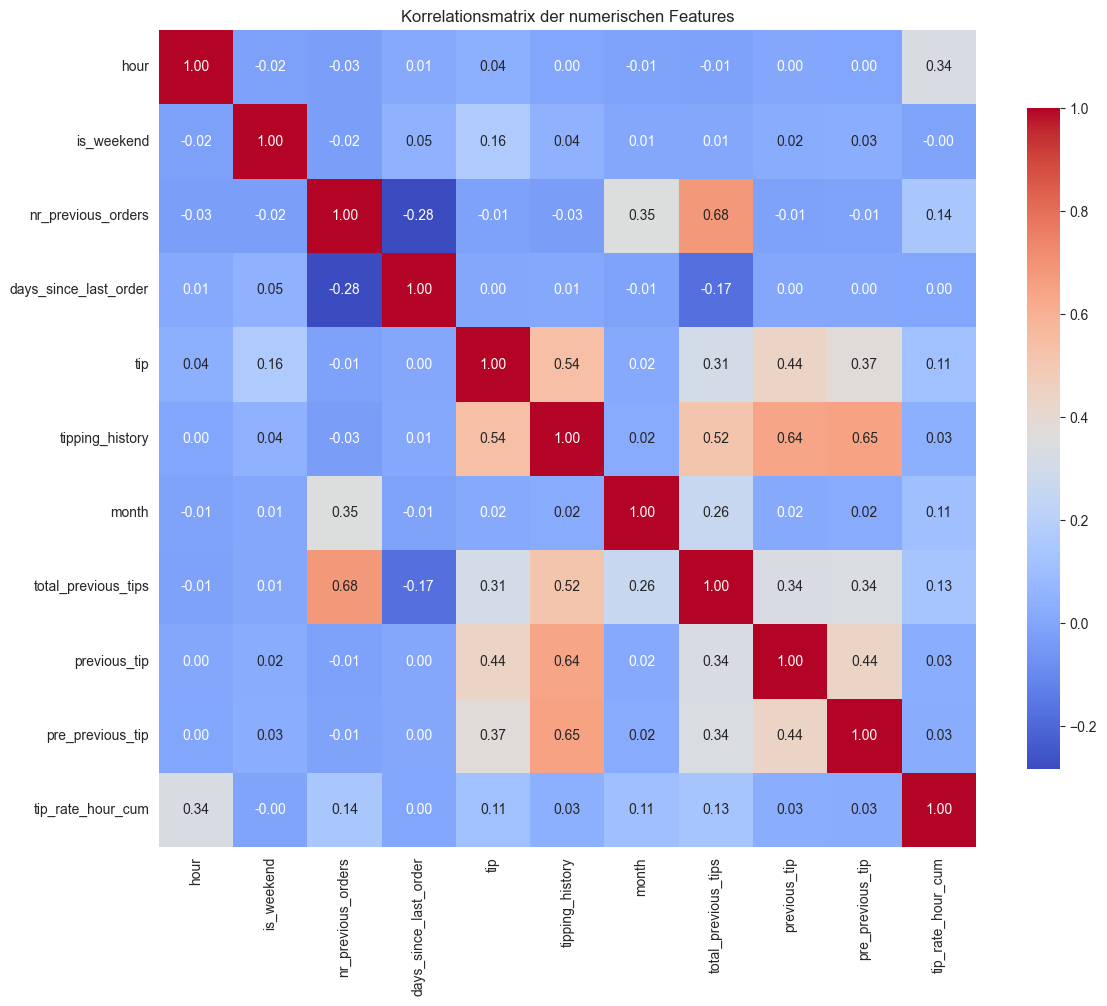

In [16]:
# Entferne unwichtige Spalten:
columns_to_drop = [col for col in ['Unnamed: 0', 'user_id', 'order_id', 'order_date'] if col in orders_and_tips.columns]
df_corr = orders_and_tips.drop(columns=columns_to_drop)

# Entferne NaN-Zeilen für die relevanten Spalten
df_corr = df_corr.dropna(subset=['tip', 'previous_tip', 'pre_previous_tip'])

# Konvertiere boolean Spalten zu int
for col in ['tip', 'previous_tip', 'pre_previous_tip']:
    df_corr[col] = df_corr[col].astype(int)

# Jetzt: Nur numerische Spalten auswählen
numeric_df = df_corr.select_dtypes(include=['number'])

# Korrelationsmatrix berechnen
corr_matrix = numeric_df.corr()

# Visualisierung
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
plt.title("Korrelationsmatrix der numerischen Features")
plt.tight_layout()
plt.show()

## Relevante Fatures zur Nutzung im Modell (wichtige Korrelationen):

- tipping_history (0.54)
- previous_tip (0.44)
- pre_previous_tip (0.37)
- tip_rate_hour_cum (0.11)
- total_previous_tips (0.31)
- is_weekend (0.16)
- hour (0.04)
- month (0.02)

Nicht im Modell enthalten sein sollen: nr_previous_orders, days_since_last_order, weekday, week-start, month-period

***

# (5) Main Task A: Train Classification Model (Random Forest)

In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# 1. Spalten droppen, die wir nicht als Features verwenden wollen
features_to_drop = ['days_since_last_order', 'weekday', "week-start", "month-period", 'nr_previous_orders', 'is_weekend', 'hour']

data = orders_and_tips.drop(columns=features_to_drop)

# 2. Letzte Bestellung pro Nutzer als Testset extrahieren
last_order_idx = data.groupby("user_id")["order_date"].idxmax()
test_set = data.loc[last_order_idx]

# 3. Trainingsdaten: alle Bestellungen außer die letzte pro Nutzer
train_set = data.drop(index=last_order_idx)

# 4. Sortieren nach Nutzer & Bestelldatum (optional, für Reproduzierbarkeit)
train_set = train_set.sort_values(by=["user_id", "order_date"])
test_set = test_set.sort_values(by=["user_id", "order_date"])

# 5. Features und Target definieren
columns_to_remove = ['user_id', 'order_id', 'order_date', 'tip']

X_train = train_set.drop(columns=columns_to_remove)
y_train = train_set['tip']

X_test = test_set.drop(columns=columns_to_remove)
y_test = test_set['tip']

# 6. NaN-Werte entfernen (sicherheitshalber, falls noch vorhanden)
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

In [69]:
# 7. Check X-Trainset

X_train.head(10)

,tipping_history,total_previous_tips,previous_tip,pre_previous_tip
2,0.500000,1,False,True
3,0.333333,1,False,False
4,0.250000,1,False,False
5,0.400000,2,True,False
6,0.500000,3,True,True
7,0.428571,3,False,True
8,0.375000,3,False,False
9,0.333333,3,False,False
10,0.300000,3,False,False
15,0.000000,0,False,False


In [63]:
# 7. Check X-Testset

X_test.head(10)

,tipping_history,total_previous_tips,previous_tip,pre_previous_tip
11,0.272727,3,False,False
16,0.000000,0,False,False
20,1.000000,2,True,True
33,1.000000,11,True,True
56,0.238095,5,True,False
63,0.800000,4,True,True
73,0.125000,1,True,False
155,0.100000,8,True,False
174,0.176471,3,False,False
195,0.000000,0,False,False


In [64]:
# 8. Check y-Trainset

y_train.head(10)

2     False
3     False
4      True
5      True
6     False
7     False
8     False
9     False
10    False
15    False
Name: tip, dtype: bool

In [65]:
# 8. Check y-Testset

y_test.head(10)

11      True
16     False
20      True
33      True
56     False
63      True
73      True
155    False
174    False
195    False
Name: tip, dtype: bool

In [90]:
# 9. Random Forest Modell trainieren

from sklearn.metrics import confusion_matrix


clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=4,           # Tiefe begrenzen auf 4
    min_samples_split=10,  # Mind. Proben für Split
    min_samples_leaf=5,    # Mind. Proben pro Blatt
    max_features='log2',   # Anzahl der Features pro Split = log2(Anzahl aller Features)
    random_state=42,
    verbose=1
)

clf.fit(X_train, y_train)

# 10. Modell auswerten
print(f"Train Accuracy: {clf.score(X_train, y_train):.3f}")
print(f"Test Accuracy: {clf.score(X_test, y_test):.3f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, clf.predict(X_test)))
print("\nClassification Report:")
print(classification_report(y_test, clf.predict(X_test)))

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   46.7s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.0s finished


Train Accuracy: 0.739


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Test Accuracy: 0.751

Confusion Matrix:


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


[[27342  6878]
 [ 8544 19268]]

Classification Report:
              precision    recall  f1-score   support

       False       0.76      0.80      0.78     34220
        True       0.74      0.69      0.71     27812

    accuracy                           0.75     62032
   macro avg       0.75      0.75      0.75     62032
weighted avg       0.75      0.75      0.75     62032



[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Auswertung:

- Von den tatsächlich „False“ wurden ca. 80% richtig erkannt (Recall False = 27434 / 34220).

- Von den tatsächlich „True“ wurden ca. 71% richtig erkannt (Recall True = 19787 / 27812).

Das heißt:

- False-Positives (fälschlich als True erkannt): 6786

- False-Negatives (fälschlich als False erkannt): 8025

***

# (6) Main Task B: Probability Prediction of Tips (incl. Log-Loss)

In [66]:
from sklearn.metrics import log_loss, confusion_matrix, classification_report

# Wahrscheinlichkeiten vorhersagen
y_proba = clf.predict_proba(X_test)[:, 1]

# Log-Loss ausgeben
loss = log_loss(y_test, y_proba)
print(f"Log-Loss: {loss:.4f}")

# Wahrscheinlichkeiten für Klasse "True" (angenommen, Label = 1)
probs = clf.predict_proba(X_test)[:, 1]

# Wahre Labels
y_true = y_test.values

# Individuellen Log-Loss pro Beispiel berechnen
individual_log_loss = -(y_true * np.log(probs) + (1 - y_true) * np.log(1 - probs))

# Ausgabe der ersten 10 Beispiele mit: Index, Wahre Klasse, Vorhergesagte Wahrscheinlichkeit, Log-Loss
print("Index\tTrue Label\tW'keit\t        Log-Loss")
for i in range(10):
      print(f"{i}\t{y_true[i]}\t\t{probs[i]:.4f}\t\t{individual_log_loss[i]:.4f}")

Log-Loss: 0.4975
Index	True Label	W'keit	        Log-Loss
0	True		0.3598		1.0221
1	False		0.1632		0.1782
2	True		0.8147		0.2049
3	True		0.8342		0.1813
4	False		0.4811		0.6560
5	True		0.7232		0.3241
6	True		0.3175		1.1473
7	False		0.4463		0.5912
8	False		0.1885		0.2089
9	False		0.1269		0.1357


Interpretation:

- Log-Loss kann theoretisch von 0 (perfekt) bis unendlich gehen.

- Ein komplett zufälliges Modell, das immer 0.5 für beide Klassen vorhersagt, hat einen Log-Loss von etwa 0.693.

- 0.4986 ist also deutlich besser als zufällig, aber nicht „sehr gut“

- Das Modell erreicht 76 % Accuracy — das bedeutet, dass 3 von 4 Fällen korrekt klassifiziert werden.

- Der Log-Loss von 0.4986 zeigt, dass die Wahrscheinlichkeiten einiger Vorhersagen nicht sehr sicher sind oder teilweise falsch kalibriert (z.B. Wahrscheinlichkeiten nahe 0.5, obwohl die Klasse klar ist).

Es gibt also noch Verbesserungspotenzial bei der Konfidenz der Wahrscheinlichkeiten, auch wenn die Klasse oft richtig getroffen wird.

***

# (7) Preparation of Final Submission (.csv-files) - includes a preparation of used features and predicted values

### Vorbereitung des finalen Testsets für die Abgabe

In [39]:
#load .csv file
template_df = pd.read_csv("tip25_testdata_template.csv")
template_df.head

<bound method NDFrame.head of        Unnamed: 0  order_id  tip
0              17   2196797  NaN
1              34   1827621  NaN
2              64   2461523  NaN
3             156   2614670  NaN
4             175   3110252  NaN
...           ...       ...  ...
39414     1463304   2078948  NaN
39415     1463309    674892  NaN
39416     1463360    147265  NaN
39417     1463388   1521740  NaN
39418     1463428    243575  NaN

[39419 rows x 3 columns]>

In [40]:
#Create Raw Data Dataset based on transformed dataframe "orders" including all NaN-Values and Last Orders
target_data_prediction = pd.merge(orders, tips, on="order_id", how="left") 
target_data_prediction

,order_id,user_id,order_date,weekday,hour,week-start,is_weekend,nr_previous_orders,days_since_last_order,month-period,Unnamed: 0,tip
0,1374495,3,2024-03-31 14:05:18,Sunday,14,2024-03-25,1,0,0,End,0.0,True
1,444309,3,2024-04-09 19:45:51,Tuesday,19,2024-04-08,0,1,9,Start,1.0,False
2,3002854,3,2024-04-30 16:25:20,Tuesday,16,2024-04-29,0,2,20,End,2.0,False
3,2037211,3,2024-05-20 18:31:28,Monday,18,2024-05-20,0,3,20,Middle,3.0,False
4,2710558,3,2024-06-01 17:52:27,Saturday,17,2024-05-27,1,4,11,Start,4.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...
1463627,3059777,206208,2025-02-09 10:08:18,Sunday,10,2025-02-03,1,45,12,Start,1463627.0,True
1463628,2239861,206208,2025-02-18 04:40:09,Tuesday,4,2025-02-17,0,46,8,Middle,1463628.0,True
1463629,1285346,206208,2025-02-23 11:33:43,Sunday,11,2025-02-17,1,47,5,End,1463629.0,True
1463630,1882108,206208,2025-03-02 22:18:46,Sunday,22,2025-02-24,1,48,7,Start,1463630.0,True


In [41]:
# Add all Features we defined for target_data_prediction

#Testing User Tip-Rate (Tipping_History)
target_data_prediction = target_data_prediction.sort_values(["user_id","order_date"]) #Making sure it´s sorted again
target_data_prediction["tipping_history"] = target_data_prediction.groupby("user_id")["tip"].apply(lambda x: x.shift().expanding().mean()).reset_index(level=0, drop=True)
target_data_prediction.head(20)

# Add Month
target_data_prediction['month'] = target_data_prediction['order_date'].dt.month

# Noch Previous und Pre-Previous Tips übernommen (erhalten dadurch NaN-Werte)
target_data_prediction = target_data_prediction.sort_values(['user_id', 'order_date']) # Making sure it´s sorted again

target_data_prediction['previous_tip'] = target_data_prediction.groupby("user_id")['tip'].shift(1)
target_data_prediction['pre_previous_tip'] = target_data_prediction.groupby("user_id")['tip'].shift(2)

# Anzahl vorheriger Tips (total previous tips)
target_data_prediction['tip'] = target_data_prediction['tip'].astype(bool) 
target_data_prediction["total_previous_tips"] = target_data_prediction.groupby("user_id")["tip"].cumsum() - target_data_prediction["tip"] # Tip abziehen, da cumsum kumulative Summe inklusiver aktueller Zeile ist, aber diese Information in Zelle nicht vorliegt (Zeitreihe)

#Kumulative Tipp-Rate-Hour

orders_and_tips = orders_and_tips.sort_values("order_date") # Sortiere nach Zeit, falls noch nicht geschehen

# Berechne kumulative Tipp-Rate je Stunde (ohne Leakage)
target_data_prediction['tip_rate_hour_cum'] = (
    target_data_prediction
    .groupby('hour')['tip']
    .transform(lambda x: x.shift().expanding().mean())
)

# Optional: Ersetze NaNs durch globalen Tipp-Mittelwert
global_tip_mean_target = target_data_prediction['tip'].mean()
target_data_prediction['tip_rate_hour_cum'] = target_data_prediction['tip_rate_hour_cum'].fillna(global_tip_mean_target)

target_data_prediction

,order_id,user_id,order_date,weekday,hour,week-start,is_weekend,nr_previous_orders,days_since_last_order,month-period,Unnamed: 0,tip,tipping_history,month,previous_tip,pre_previous_tip,total_previous_tips,tip_rate_hour_cum
0,1374495,3,2024-03-31 14:05:18,Sunday,14,2024-03-25,1,0,0,End,0.0,True,NaN,3,NaN,NaN,0,0.503468
1,444309,3,2024-04-09 19:45:51,Tuesday,19,2024-04-08,0,1,9,Start,1.0,False,1.000000,4,True,NaN,1,0.503468
2,3002854,3,2024-04-30 16:25:20,Tuesday,16,2024-04-29,0,2,20,End,2.0,False,0.500000,4,False,True,1,0.503468
3,2037211,3,2024-05-20 18:31:28,Monday,18,2024-05-20,0,3,20,Middle,3.0,False,0.333333,5,False,False,1,0.503468
4,2710558,3,2024-06-01 17:52:27,Saturday,17,2024-05-27,1,4,11,Start,4.0,True,0.250000,6,False,False,1,0.503468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463627,3059777,206208,2025-02-09 10:08:18,Sunday,10,2025-02-03,1,45,12,Start,1463627.0,True,0.711111,2,False,True,32,0.497484
1463628,2239861,206208,2025-02-18 04:40:09,Tuesday,4,2025-02-17,0,46,8,Middle,1463628.0,True,0.717391,2,True,False,33,0.602178
1463629,1285346,206208,2025-02-23 11:33:43,Sunday,11,2025-02-17,1,47,5,End,1463629.0,True,0.723404,2,True,True,34,0.487396
1463630,1882108,206208,2025-03-02 22:18:46,Sunday,22,2025-02-24,1,48,7,Start,1463630.0,True,0.729167,3,True,True,35,0.641982


In [42]:
# Filtern: nur die Bestellungen, die auch im vorgegebenen "tip25_testdata_template.csv" Testset vorkommen
target_data_prediction_filtered = target_data_prediction[target_data_prediction["order_id"].isin(template_df["order_id"])].copy()
target_data_prediction_filtered

,order_id,user_id,order_date,weekday,hour,week-start,is_weekend,nr_previous_orders,days_since_last_order,month-period,Unnamed: 0,tip,tipping_history,month,previous_tip,pre_previous_tip,total_previous_tips,tip_rate_hour_cum
17,2196797,5,2024-05-18 11:26:30,Saturday,11,2024-05-13,1,4,5,Middle,NaN,True,0.000000,5,False,False,0,0.503468
34,1827621,13,2024-06-29 21:09:43,Saturday,21,2024-06-24,1,12,8,End,NaN,True,1.000000,6,True,True,12,1.000000
64,2461523,18,2024-03-08 09:08:45,Friday,9,2024-03-04,0,6,6,Start,NaN,True,0.833333,3,True,True,5,0.400000
156,2614670,27,2025-03-20 14:26:50,Thursday,14,2025-03-17,0,81,4,Middle,NaN,True,0.098765,3,False,True,8,0.150000
175,3110252,29,2024-08-28 11:10:43,Wednesday,11,2024-08-26,0,18,13,End,NaN,True,0.166667,8,False,False,3,0.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463304,2078948,206155,2024-06-18 11:59:24,Tuesday,11,2024-06-17,0,14,14,Middle,NaN,True,0.857143,6,True,True,12,0.487393
1463309,674892,206156,2024-05-01 19:00:51,Wednesday,19,2024-04-29,0,4,5,Start,NaN,True,0.750000,5,True,True,3,0.613275
1463360,147265,206158,2025-03-09 10:11:36,Sunday,10,2025-03-03,1,50,7,Start,NaN,True,0.740000,3,True,True,37,0.497495
1463388,1521740,206165,2024-12-27 00:32:28,Friday,0,2024-12-23,0,27,1,End,NaN,True,0.111111,12,False,False,3,0.633782


In [43]:
# Spalten droppen, die wir nicht als Features verwendet haben
target_data_prediction_filtered_cleaned = target_data_prediction_filtered.copy()
columns_to_drop = ['nr_previous_orders', 'days_since_last_order', 'weekday', "week-start", "month-period", "user_id", "order_date", "tip", "Unnamed: 0"]

target_data_prediction_filtered_cleaned = target_data_prediction_filtered_cleaned.drop(columns=columns_to_drop)
target_data_prediction_filtered_cleaned.columns

Index(['order_id', 'hour', 'is_weekend', 'tipping_history', 'month',
       'previous_tip', 'pre_previous_tip', 'total_previous_tips',
       'tip_rate_hour_cum'],
      dtype='object')

In [44]:
# data und csv. mergen

# Testdaten mit order_ids aus Vorlage
test_template = template_df.copy()

# Sicherstellen, dass 'order_id' in beiden DataFrames vorhanden ist
assert 'order_id' in test_template.columns
assert 'order_id' in target_data_prediction_filtered_cleaned.columns

# Merge anhand von order_id, um Features zu bekommen
merged_df = test_template.merge(
    target_data_prediction_filtered_cleaned,
    on='order_id',
    how='left'
)

In [45]:
merged_df

,Unnamed: 0,order_id,tip,hour,is_weekend,tipping_history,month,previous_tip,pre_previous_tip,total_previous_tips,tip_rate_hour_cum
0,17,2196797,NaN,11,1,0.000000,5,False,False,0,0.503468
1,34,1827621,NaN,21,1,1.000000,6,True,True,12,1.000000
2,64,2461523,NaN,9,0,0.833333,3,True,True,5,0.400000
3,156,2614670,NaN,14,0,0.098765,3,False,True,8,0.150000
4,175,3110252,NaN,11,0,0.166667,8,False,False,3,0.300000
...,...,...,...,...,...,...,...,...,...,...,...
39414,1463304,2078948,NaN,11,0,0.857143,6,True,True,12,0.487393
39415,1463309,674892,NaN,19,0,0.750000,5,True,True,3,0.613275
39416,1463360,147265,NaN,10,1,0.740000,3,True,True,37,0.497495
39417,1463388,1521740,NaN,0,0,0.111111,12,False,False,3,0.633782


In [46]:
# Features, die zum Trainieren verwendet
feature_columns = [
    'hour', 'is_weekend', 'tipping_history', 'month',
    'previous_tip', 'pre_previous_tip', 'tip_rate_hour_cum', 'total_previous_tips', "Unnamed: 0"
]

# Sicherstellen, dass keine NaNs vorliegen (ggf. auf Imputing-Strategie zurückgreifen)
X_pred = merged_df[feature_columns]

### Erzeuge .csv Dateien

In [47]:
# Reihenfolge der Features aus dem Training
X_pred = merged_df[X_train.columns]

# Klassifikation (True/False)
merged_df['tip'] = clf.predict(X_pred)

# Nur relevante Spalten exportieren
task_a_output = merged_df[["Unnamed: 0", 'order_id', 'tip']]

# Als CSV speichern
task_a_output.to_csv('Team_2_submission_A.csv', index=False)

In [48]:
# Reihenfolge der Features aus dem Training
X_pred = merged_df[X_train.columns]

# Wahrscheinlichkeiten (nur Spalte für Klasse "True" = 1)
merged_df['tip'] = clf.predict_proba(X_pred)[:, 1]

# Ausgabe
task_b_output = merged_df[["Unnamed: 0", 'order_id', 'tip']]

# Als CSV speichern
task_b_output.to_csv('Team_2_submission_B.csv', index=False)

***

# (8) Questions: 
- Ist unsere Aufgabe ein <u>"bestmögliches Ergebnis für diesen Datensatz"</u> zu erstellen oder ein <u> allgemeines Modell </u>, d.h. sind userspezifische Historien zur Vorhersage zulässig? 

- Sind NaN-Werte von previous und pre-previous Tip wichtig für weiteren Umgang & Prediction (da Personen, die noch nicht mindestens 3 Bestellungen getätigt haben, mindestens einen NaN-Wert hier haben werden)? Erzeugt das ein Ungleichgewicht / Bias?

***
Notizen: 
In unserem Projekt sind 81% Accuracy mit perfektem Modell möglich (nur endlich viele Daten, daher nicht erreichbar, aber das wäre perfektes Modell)
Kann nicht abschätzen wie nah man realistisch ran kommt
***

Entscheidungsbäume haben Probleme mit NA bei Features, die man nutzen will (darauf ist zu achten!) 
- am einfachsten ist es ein Ersatzwert reinzuschreiben (zusätzlicher Wert kreieren für "is_missing") - bei diskreten Attributen ist ein weiterer Wert (nominal) nicht problematisch - Median oder Mittelwert als Ersatz reinsetzen wäre auch ok (nicht perfekt, aber einfach) - Ersatzwerte ausreichend 
***


Feedback:

Schätzen bisher recht akkurat (Log-Loss noch nicht so gut wie Accuracy, aber Accuracy sehr gut)
- bei beiden oben dabei 
- Score A nicht ganz Top, aber noch ziemlich gut (obere Gruppe in Mitte)
- Score B sind 2 Teams besser (aber sind im oberen Cluster)

Für Accuracy ist Feature Engineering wichtiger als Modelltyp / Parameter / etc. (bißchen, aber Features sind wichtiger)
- bei Log-Loss Score kann man an Modellierungsseite noch etwas mehr bewirken 

Feature im Detail
- sekundäre Einflussgrößen gibt es noch, die etwas komplizierter sind
- days_since_last_order ist komplex noch etwas drin (gewisser Zusammenhang, nicht sehr stark, aber liegt vor)
- Inhalt der Bestellung ist noch etwas drin, das man nutzen kann (also departments z.B. noch als binäres Feature z.B. nutzen, doch noch mit rein - weil man nicht alle mit rein kann, da es zu viele departments / Produkte gibt, daher lieber simpel kodieren)
- in vielen Features auf Ebene tiefer fragen ,wie man das genau macht und wie man tipping_history zusammenfasst (aber da 3 Features zu tipping drin, daher vermutlich das meiste enthalten)

Dürfen userspezifische Features generieren (Modell ist trotzdem universell für User, muss ja kein erstbestellender User sein)

Trainiert natürlich mehr auf Usern mit vielen Bestellungen - wenn diese sich systematisch anders verhalten, wäre das problematisch, aber sonst nicht
. schauen ob man Indizien dafür findet, aber vermutlich nicht (z.B. Tip Rate mit Anzahl Bestellungen des Users Korrelation)
- scheint aber kein Problem zu sein

### Optimisation von Hyperparametern und Suche nach dem Bestmodell



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": BernoulliNB(),
    "Decision Tree": DecisionTreeClassifier(max_depth=5)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"\n{name} Accuracy: {accuracy_score(y_test, preds):.4f}")
    print(classification_report(y_test, preds))


--> im Vergleich mit Logistic Regression, Bernoulli Naive Bayes und Decision tree Decision tree hat bessere Accuracy.

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

params = {
    "n_estimators": [50, 100, 200],
    "max_depth": [4, 6, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

search = RandomizedSearchCV(clf, param_distributions=params, n_iter=20, cv=5, scoring='accuracy', n_jobs=-1, random_state=42, verbose=1)
search.fit(X_train, y_train)

best_rf = search.best_estimator_
print(f"Best RF Accuracy: {accuracy_score(y_test, best_rf.predict(X_test)):.4f}")


### Neuronal Network approach

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tf_keras.src import regularizers
from tf_keras.src.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from tf_keras import Sequential
from tf_keras.src.initializers.initializers import GlorotUniform
from tf_keras import optimizers
from tf_keras.src.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import StandardScaler

2025-06-19 23:04:34.727992: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [77]:
# 2) Scale continuous features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [78]:
# 3) Build the model with better init, activations, regularization

model = Sequential([
    Dense(64, input_shape=(X_train.shape[1],),
          kernel_initializer=GlorotUniform(seed=42),
          kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.4),

    Dense(32,
          kernel_initializer=GlorotUniform(seed=43),
          kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.3),

    Dense(16,
          kernel_initializer=GlorotUniform(seed=44),
          kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])
model

In [79]:
# 4) Compile with Adam and a reasonable LR
optimizer = optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [80]:
# 5) Define callbacks: early stop, LR reduction, and checkpointing
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

In [83]:

# 6) Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
30388/30388 [==============================] - ETA: 0s

ValueError: Unexpected result of `train_function` (Empty logs). This could be due to issues in input pipeline that resulted in an empty dataset. Otherwise, please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

In [ ]:
# 7) Final evaluation on train and test
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc   = model.evaluate(X_test,  y_test,  verbose=0)
print(f"▶️ Training   — Loss: {train_loss:.4f} · Acc: {train_acc:.4f}")
print(f"▶️ Test       — Loss: {test_loss:.4f} · Acc: {test_acc:.4f}")

In [ ]:
# 8) Plot training history to diagnose under/over‑fitting
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'],   label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'],   label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### XGBoost

In [70]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

In [71]:
X_train['previous_tip'] = X_train['previous_tip'].astype(bool)
X_train['pre_previous_tip'] = X_train['pre_previous_tip'].astype(bool)

X_test['previous_tip'] = X_test['previous_tip'].astype(bool)
X_test['pre_previous_tip'] = X_test['pre_previous_tip'].astype(bool)

In [72]:
# Hyperparameterraum definieren
param_dist = {
    'n_estimators': np.arange(200, 300, 500),
    'max_depth': np.arange(3, 4, 6),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'subsample': np.linspace(0.6, 1.0, 5),
    'colsample_bytree': np.linspace(0.6, 1.0, 5),
    'gamma': np.linspace(0, 5, 10),
    'reg_alpha': np.logspace(-4, 1, 10),
    'reg_lambda': np.logspace(-4, 1, 10)
}

# TimeSeriesSplit für zeitabhängige Validierung
tscv = TimeSeriesSplit(n_splits=5)

In [73]:
# XGBoost-Modell
xgb_model = XGBClassifier(objective='binary:logistic', enable_categorical=True, random_state=42)

# Randomized Search mit Cross-Validation
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,                    # Anzahl der zufälligen Kombinationen
    cv=3,
    scoring='accuracy',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Suche starten
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=True,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraint...
       1.66810054e-02, 5.99484250e-02, 2.15443469e-01, 7.74263683e-01,
       2.78255940e+00, 1.00000000e+01]),
                                        'reg_lambda': array([1.00000000e-04, 3.59381366e-04, 1.29154967e-03, 4.64158883e-03,
       1.66810054e-02, 5.99484250e-02, 2.15443469e-01, 7.74263683e-01,
       2.78255940e+00, 1.00000000e+01]),
                                        'subsample': array([0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=42, scoring='accuracy', verbose=2)

In [74]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Bestes Modell und Score ausgeben
print("Best Parameters:", random_search.best_params_)
print("Best RMSE:", random_search.best_score_)

# Predictions
preds = random_search.predict(X_test)

Best Parameters: {'subsample': 0.6, 'reg_lambda': 0.21544346900318845, 'reg_alpha': 0.0001, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.10666666666666666, 'gamma': 0.5555555555555556, 'colsample_bytree': 0.8}
Best RMSE: 0.7396849372770472


In [75]:

from sklearn.metrics import accuracy_score, classification_report
print(f"Accuracy: {accuracy_score(y_test, preds):.4f}")
print(classification_report(y_test, preds))

Accuracy: 0.7507
              precision    recall  f1-score   support

       False       0.77      0.79      0.78     34220
        True       0.73      0.70      0.72     27812

    accuracy                           0.75     62032
   macro avg       0.75      0.75      0.75     62032
weighted avg       0.75      0.75      0.75     62032

